In [2]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
from numpy.lib.format import open_memmap
from numpy.lib.format import read_magic, read_array_header_1_0, read_array_header_2_0

# ====== Reading in data ===
def load_split(file_path):
    with h5py.File(file_path, "r") as f:
        high = f["/high_count/data"][:].transpose(2, 0, 1)  # (N,H,W)
        low  = f["/low_count/data"][:].transpose(2, 0, 1)
    return high, low

DATA_DIR = Path("data") / "original_data"

data = {
    "train": load_split(DATA_DIR / "training_data.hdf5"),
    "test":  load_split(DATA_DIR / "test_data.hdf5"),
    "val":   load_split(DATA_DIR / "validation_data.hdf5"),
}

In [3]:
# ================= Normalising Data =================
def anscombe_vst(x):
    """
    Negative values get yeeted to zero (counts should not be negative)
    """
    x = np.maximum(x, 0)
    return 2.0 * np.sqrt(x + 3.0/8.0)

def compute_clip_from_high(high_data, percentile=99.9, use_vst=True, max_samples=5_000_000, rng=None):
    """
    From High count data, determine global Clip_values
    percentile: e.g. 99.9
    use_vst: If True -> Calculate Clip on VSC domain (usually better)
    """
    rng = np.random.default_rng() if rng is None else rng
    arr = high_data.ravel()
    sample = arr if arr.size <= max_samples else arr[rng.choice(arr.size, size=max_samples, replace=False)]
    if use_vst:
        sample = anscombe_vst(sample)
    clip_val = np.percentile(sample, percentile)
    if not np.isfinite(clip_val) or clip_val <= 0:
        clip_val = float(np.max(sample))
    return float(clip_val)

def preprocess_counts(x, clip_val, use_vst=True, dtype=np.float32):
    """
    Normalization: optional VST -> clip -> /clip -> [0,1]
    """
    x = anscombe_vst(x) if use_vst else x
    x = np.clip(x, 0, clip_val) / clip_val
    return x.astype(dtype)

In [4]:

# ================= Build 3D Datasets =================
def build_sequential_dataset(low_data, high_data, size, group_len, dtype=np.float32):
    """
    Generates training data:
      X: (B, size, H, W) = window of `size` Low-Count images
      Y: (B, size, H, W) = Ground truth = window of `size` High-Count images (3D output)
      N: Number of Pictrues in total
      H: Height of each image
      W: Width of each image
      size: Size of sliding window (must be odd)
      group_len: Length of each block (e.g. 41 for training/test/val)
    Note: Sliding window is only applied inside each block of length `group_len`
    """
    assert low_data.shape == high_data.shape, "low/high must have identical shapes"
    N, H, W = low_data.shape
    if size % 2 == 0 or size < 1:
        raise ValueError("`size` must be odd and >= 1 (e.g., 3, 5, 7)")
    if N % group_len != 0:
        raise ValueError(f"N={N} is not a multiple of group_len={group_len}.")

    num_groups = N // group_len
    X_list, Y_list = [], []

    for group_index in range(num_groups):
        start = group_index * group_len
        end   = start + group_len
        # slide window inside this block only
        for n in range(start, end - size + 1):         # stride = 1
            X_list.append(low_data[n: n + size])       # (size,H,W)
            Y_list.append(high_data[n: n + size])      # (size,H,W)

    X = np.stack(X_list, axis=0).astype(dtype)   # (B, size, H, W)
    Y = np.stack(Y_list, axis=0).astype(dtype)   # (B, size, H, W)
    # Adding Channel-Dimension since PyTorch expects (B,C,D,H,W) with C=1
    X = X[..., None]  # (B, size, H, W, 1)
    Y = Y[..., None]  # (B, size, H, W, 1)
    return X, Y


# ===== Applying on (N,H,W) data =====
size = 5 # Adjust window size to find best value (e.g. 3,5,7)
group_len = 41

# === Normalzing Data ===
USE_VST = True
PCT = 99.9

# Saving directory
outdir = os.path.join(os.getcwd(), "data", "data_3D_U-net")
os.makedirs(outdir, exist_ok=True)


def build_and_save_windows_streaming(low_n, high_n, split_name, outdir, size=5, group_len=41, dtype=np.float32):
    """
    Writes small 3D volumes directly to the dataset using open_memmap
    Prevents RAM issues when building large datasets
    """
    assert low_n.shape == high_n.shape
    N, H, W = low_n.shape
    assert N % group_len == 0, f"N={N} no multiple of {group_len}"
    assert size % 2 == 1 and size >= 1

    outdir = os.path.normpath(outdir)
    os.makedirs(outdir, exist_ok=True)

    num_groups    = N // group_len
    win_per_group = group_len - size + 1
    B             = num_groups * win_per_group

    X_path = os.path.join(outdir, f"X_{split_name}.npy")
    Y_path = os.path.join(outdir, f"Y_{split_name}.npy")

    # Remove old files (if existing)
    for p in (X_path, Y_path):
        if os.path.exists(p):
            try:
                os.remove(p)
            except PermissionError as e:
                raise RuntimeError(f"{p} ist noch gemappt/offen. Schliess alle np.load(..., mmap_mode='r').") from e

    print("create:", repr(X_path), "and", repr(Y_path))

    X_mm = open_memmap(X_path, mode="w+", dtype=dtype, shape=(B, size, H, W, 1))
    Y_mm = open_memmap(Y_path, mode="w+", dtype=dtype, shape=(B, size, H, W, 1))

    write_idx = 0
    for g in range(num_groups):
        s = g * group_len
        e = s + group_len
        low_blk  = low_n[s:e]   # (group_len, H, W)
        high_blk = high_n[s:e]  # (group_len, H, W)
        for n in range(win_per_group):
            # low_blk[n:n+size] -> (size, H, W)
            X_mm[write_idx, ..., 0] = low_blk[n:n+size]
            Y_mm[write_idx, ..., 0] = high_blk[n:n+size]
            write_idx += 1
        del low_blk, high_blk
        gc.collect()

    del X_mm, Y_mm
    gc.collect()
    print(f"[{split_name}] saved -> shape=({B}, {size}, {H}, {W}, 1), dtype={dtype}")

results = {}

high_train, low_train = data["train"]  # (high, low)
clip_val_train = compute_clip_from_high(high_train, percentile=PCT, use_vst=USE_VST)

# Build and save datasets for each split
DTYPE_OUT = np.float32  # TODO: Check if this is really necessary? Maybe use float 16 

# Global clipping on the test set
high_train, low_train = data["train"]
clip_val_train = compute_clip_from_high(high_train, percentile=PCT, use_vst=USE_VST)

# Close open memmaps (if there are any)
try:
    del X_vis, Y_vis
except NameError:
    pass
gc.collect()


for split in ["train", "test", "val"]:
    high_split, low_split = data[split]  # (high, low)

    low_n  = preprocess_counts(low_split,  clip_val_train, use_vst=USE_VST, dtype=DTYPE_OUT)
    high_n = preprocess_counts(high_split, clip_val_train, use_vst=USE_VST, dtype=DTYPE_OUT)

    build_and_save_windows_streaming(low_n, high_n, split, outdir,
                                     size=size, group_len=group_len, dtype=DTYPE_OUT)

    del low_n, high_n
    gc.collect()

# Test if files were created
for split in ["train","test","val"]:
    for name in [f"X_{split}.npy", f"Y_{split}.npy"]:
        p = os.path.join(outdir, name)
        if os.path.exists(p):
            print(f"{name:12} exists=True  size={os.path.getsize(p)//(1024*1024)} MB")
        else:
            print(f"{name:12} exists=False size=0 MB (not yet generated)")

create: 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\X_train.npy' and 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\Y_train.npy'
[train] saved -> shape=(2960, 5, 192, 240, 1), dtype=<class 'numpy.float32'>
create: 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\X_test.npy' and 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\Y_test.npy'
[test] saved -> shape=(2738, 5, 192, 240, 1), dtype=<class 'numpy.float32'>
create: 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\X_val.npy' and 'c:\\Users\\sandr\\VS_Master_Thesis\\data\\data_3D_U-net\\Y_val.npy'
[val] saved -> shape=(740, 5, 192, 240, 1), dtype=<class 'numpy.float32'>
X_train.npy  exists=True  size=2601 MB
Y_train.npy  exists=True  size=2601 MB
X_test.npy   exists=True  size=2406 MB
Y_test.npy   exists=True  size=2406 MB
X_val.npy    exists=True  size=650 MB
Y_val.npy    exists=True  size=650 MB


In [5]:
# =========== Show size of generated dataset =======
def npy_info(path):
    with open(path, "rb") as f:
        ver = read_magic(f)
        if ver == (1, 0):
            shape, fortran_order, dtype = read_array_header_1_0(f)
        else:
            shape, fortran_order, dtype = read_array_header_2_0(f)
    return shape, dtype

print("\n=== Overview for saved data fles ===")
for split in ["train", "test", "val"]:
    for name in [f"X_{split}.npy", f"Y_{split}.npy"]:
        p = os.path.join(outdir, name)
        shape, dtype = npy_info(p)
        size_mb = os.path.getsize(p) / 1024 / 1024
        print(f"{name:12}  shape={shape}, dtype={dtype}, size={size_mb:.1f} MB")


=== Overview for saved data fles ===
X_train.npy   shape=(2960, 5, 192, 240, 1), dtype=float32, size=2601.6 MB
Y_train.npy   shape=(2960, 5, 192, 240, 1), dtype=float32, size=2601.6 MB
X_test.npy    shape=(2738, 5, 192, 240, 1), dtype=float32, size=2406.4 MB
Y_test.npy    shape=(2738, 5, 192, 240, 1), dtype=float32, size=2406.4 MB
X_val.npy     shape=(740, 5, 192, 240, 1), dtype=float32, size=650.4 MB
Y_val.npy     shape=(740, 5, 192, 240, 1), dtype=float32, size=650.4 MB


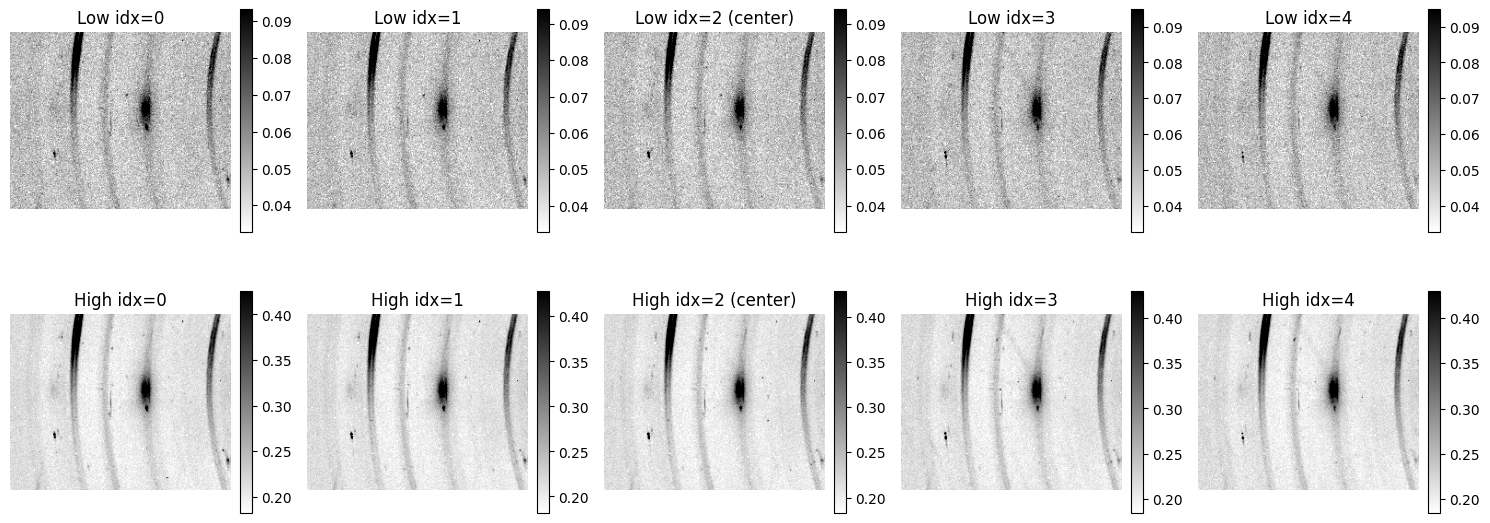

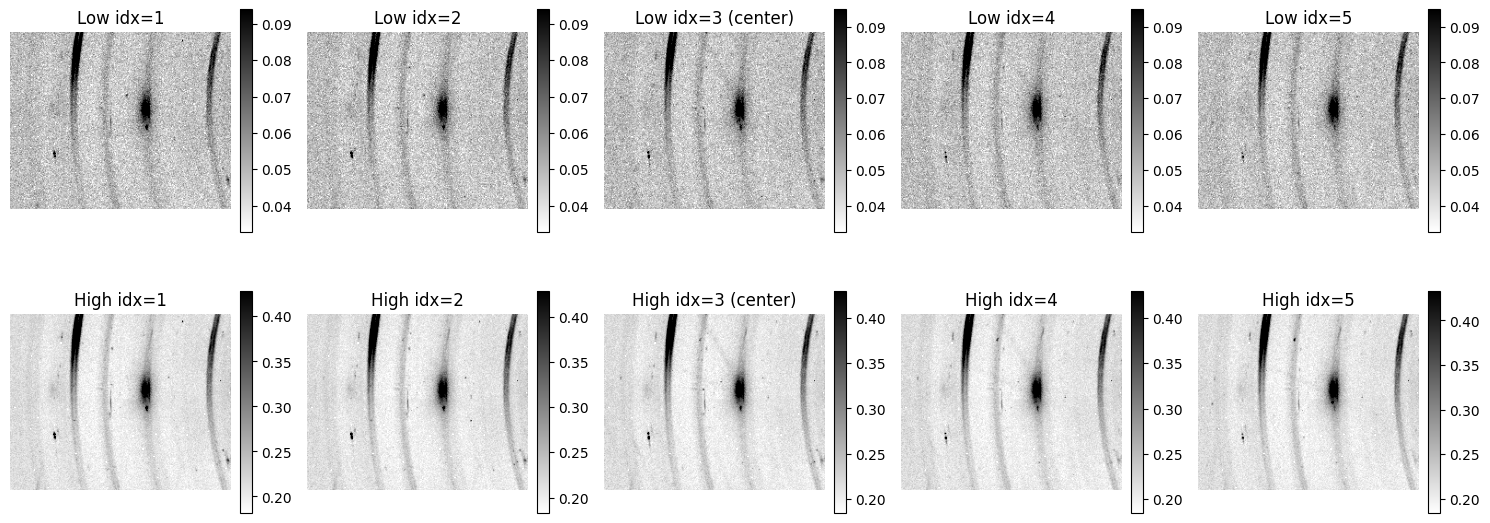

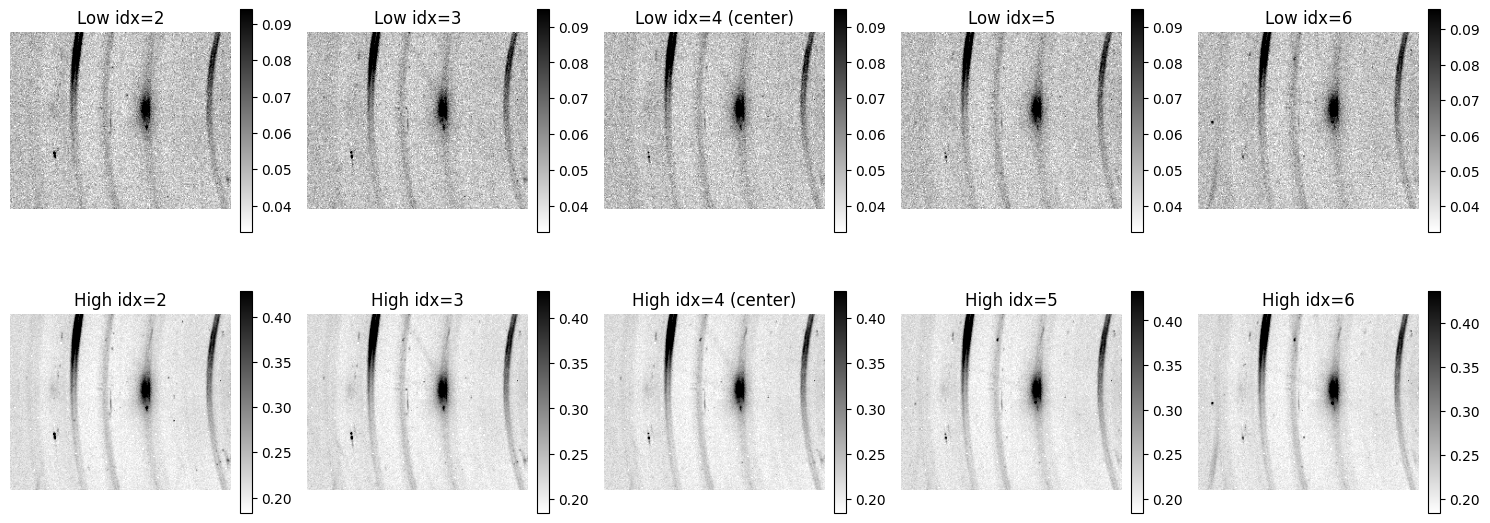

In [6]:
# ===== Visualization of some samples =====

def show_window_pair_3d(X, Y, sample_idx, size=5, group_len=41, share_scale=False):
    """
    Visualizes training sample for 3D:
      - Top: Low_Count sequence
      - Bottom: High_Count sequence

    X: (B, 1, size, H, W)  # Note: 1 is the number of channels (here 1)
    Y: (B, 1, size, H, W)
    """

    # Remove channel dimension
    seq_low = X[sample_idx]    # (1, size, H, W)
    seq_high = Y[sample_idx]   # (1, size, H, W)
    if seq_low.ndim == 4 and seq_low.shape[0] == 1:
        seq_low = seq_low[0]
        seq_high = seq_high[0]

    k = size // 2
    group_idx = sample_idx // (group_len - size + 1)
    offset_in_group = sample_idx % (group_len - size + 1)
    global_start = group_idx * group_len + offset_in_group
    frame_indices = list(range(global_start, global_start + size))

    fig, axes = plt.subplots(2, size, figsize=(3 * size, 6))

    for j in range(size):
        # Low-Count
        vmin, vmax = np.percentile(seq_low[j].ravel(), (1, 99))
        im_low = axes[0, j].imshow(
            seq_low[j], cmap="gray_r", origin="lower",
            aspect="equal", vmin=vmin, vmax=vmax
        )
        axes[0, j].set_title(f"Low idx={frame_indices[j]}")
        axes[0, j].axis("off")
        fig.colorbar(im_low, ax=axes[0, j], fraction=0.046, pad=0.04)

        # High-Count
        vmin, vmax = np.percentile(seq_high[j].ravel(), (1, 99))
        im_high = axes[1, j].imshow(
            seq_high[j], cmap="gray_r", origin="lower",
            aspect="equal", vmin=vmin, vmax=vmax
        )
        axes[1, j].set_title(f"High idx={frame_indices[j]}")
        axes[1, j].axis("off")
        fig.colorbar(im_high, ax=axes[1, j], fraction=0.046, pad=0.04)

    axes[0, k].set_title(f"Low idx={frame_indices[k]} (center)")
    axes[1, k].set_title(f"High idx={frame_indices[k]} (center)")

    plt.tight_layout()
    plt.show()

# Visualization from saved files
X_vis = np.load(os.path.join(outdir, "X_train.npy"), mmap_mode="r")
Y_vis = np.load(os.path.join(outdir, "Y_train.npy"), mmap_mode="r")

# Show some samples
for idx in range(3):
    show_window_pair_3d(X_vis, Y_vis, sample_idx=idx, size=size, group_len=group_len)